# Star-Galaxy separation and mapping the Milky Way Halo with BHB stars

<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 

<br>Contact author(s): Yumi Choi, Christina Adair <br>
Last verified to run: 2025-05-01 <br>
LSST Science Pipelines version: Weekly 2025_xx <br>
Container Size: xx <br>
Targeted learning level: xx <br>

**Learning objective:** 

**Skills:** 

**LSST Data Products:** TAP tables dp02_dc2_catalogs.Object, xxx

**Packages:** lsst, pandas, matplotlib, numpy, astropy, xxx


**Credit:**
Jeff Carlin. Adaptation of DP0.2 notebook 03_Image_Display_and_Manipulation.ipynb, DP0.2 notebook 08_Truth_Tables.ipynb, and DP0.2 deligate contribution notebook Milky_Way_halo_density.ipynb.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0-2.lsst.io">dp0-2.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there. 

## 1. Introduction

The DP0.2 dataset contains simulated stars in Milky Way [Section 5.3 in The LSST Dark Energy Science Collaboration et al. 2021](https://iopscience.iop.org/article/10.3847/1538-4365/abd62c).


This notebook adapts xxx. It demonstrates how to perform the following:

1. xxx;
2. yyy;
3. zzz.

### 1.1. Package imports

Import general python packages and the Rubin TAP service utilities.

The [`matplotlib`](https://matplotlib.org/) and [`numpy`](http://www.numpy.org/) are widely used Python libraries for plotting and scientific computing. We will use these packages below, including the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

We also use the `lsst.rsp` package to access the TAP service and query the DP0 catalogs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.wcs import WCS
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.stats import binned_statistic_2d as stat2d

from lsst.rsp import get_tap_service
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay

### 1.2. Define parameters

Set the default display backend for `afwDisplay` to `matplotlib` using the `setDefaultBackend()` function.

In [2]:
afwDisplay.setDefaultBackend('matplotlib')

Set the parameters of `matplotlib.pyplot` to give us a large default size for an image, and set some other parameters to make the default plot style be color-blind friendly and otherwise make plots look nice.

In [3]:
params = {'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 10,
          'xtick.minor.size': 5,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 10,
          'ytick.minor.size': 5,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }
plt.rcParams.update(params)

In [4]:
plt.style.use('tableau-colorblind10')

plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#56b4e9', 'g': '#008060', 'r': '#ff4000',
                      'i': '#850000', 'z': '#6600cc', 'y': '#000000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v',
                       'i': 's', 'z': '*', 'y': 'p'}

## 2. Star-Galaxy separation

Ensure robust star/galaxy classification, especially at faint magnitudes where rising galaxy counts and shrinking angular sizes degrade separation performance. Misclassified galaxies can contaminate stellar samples, compromising science cases—particularly for detecting rare halo structures.

### 2.1. Investigate star-galaxy separation performance with random objects 

#### 2.1.1. Query random 50000 objects
Retreive $u,g,r,i$ magnitudes and `repExtendedness` for 50000 random objects.


Instantiate the TAP service.

In [5]:
service = get_tap_service("tap")
assert service is not None

In [6]:
query = """
        SELECT TOP 50000
        scisql_nanojanskyToAbMag(u_psfFlux) AS umag, 
        scisql_nanojanskyToAbMag(g_psfFlux) AS gmag, 
        scisql_nanojanskyToAbMag(r_psfFlux) AS rmag,
        refExtendedness
        FROM dp02_dc2_catalogs.Object
        Where detect_isPrimary = 1
        AND u_psfFlux > 360
        """

Run the query as an asynchronous job.

In [7]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Fetch the results and convert them to an Astropy table, then take a look at the table.

In [8]:
results = job.fetch_result().to_table()
results

umag,gmag,rmag,refExtendedness
float64,float64,float64,float64
23.589240996446073,23.646950411066378,23.35965018196427,1.0
24.523202165247355,24.180330895346703,24.09828276266149,1.0
24.576963216829384,24.338828226033673,23.86733194611375,1.0
24.250666545485455,24.198580482398818,23.897855486998203,1.0
24.57576165825434,24.139174476851426,23.54595950478498,1.0
23.446175509092527,23.454875329674223,22.994728999716084,1.0
24.611496629629315,23.69598783834222,23.24675186004562,1.0
23.48224216866288,23.586070108093267,23.590612262505317,1.0
24.70373449896387,24.752859419197794,24.205020401437338,1.0


#### 2.1.2 Extendedness of the retreived objects

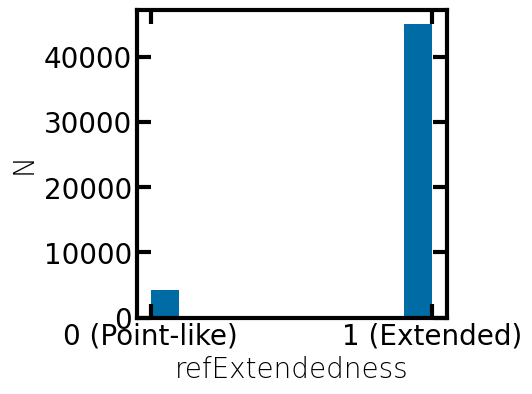

In [9]:
plt.figure(figsize=(4,4))
h = plt.hist(results['refExtendedness'])
plt.xlabel('refExtendedness')
plt.ylabel('N')
plt.xticks([0, 1], ['0 (Point-like)', '1 (Extended)'])
plt.show()

#### 2.1.3. Plot ($g-r$,$g$) color-magnitude diagram and $g-r$ vs. $u-g$ color-color diagram

In [12]:
stars = results['refExtendedness'] < 0.5

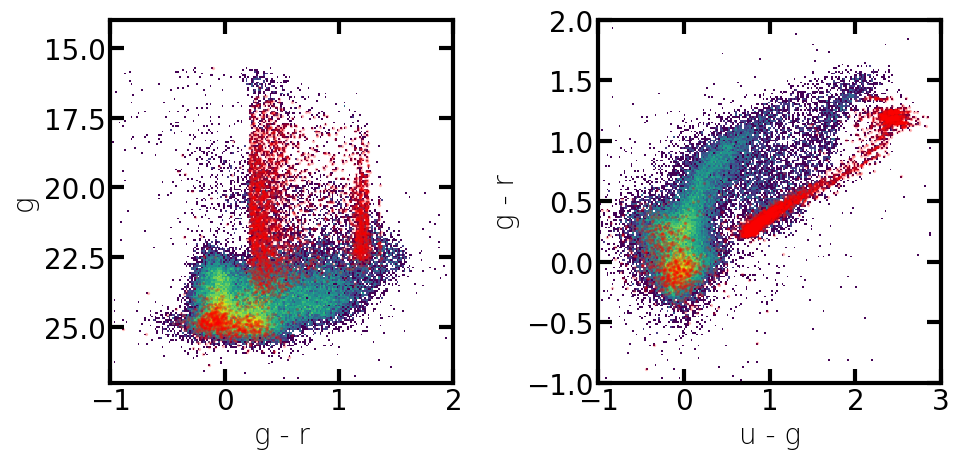

In [19]:
plt.figure(figsize=(10,5))

plt.subplot(121)
h = plt.hist2d(results['gmag']-results['rmag'], results['gmag'], 
               bins=200, range=((-1,2),(14,27)), norm=LogNorm())
plt.scatter(results['gmag'][stars]-results['rmag'][stars], results['gmag'][stars], c='r', s=2, alpha=0.2)
plt.xlabel('g - r')
plt.ylabel('g')
plt.xlim(h[1].min(),h[1].max())
plt.ylim(h[2].max(),h[2].min())

plt.subplot(122)
h = plt.hist2d(results['umag']-results['gmag'], results['gmag']-results['rmag'], 
               bins=200, range=((-1,3),(-1,2)), norm=LogNorm())
plt.scatter(results['umag'][stars]-results['gmag'][stars], results['gmag'][stars]-results['rmag'][stars], c='r', s=2, alpha=0.2)
plt.xlim(h[1].min(),h[1].max())
plt.ylim(h[2].min(),h[2].max())
plt.xlabel('u - g')
plt.ylabel('g - r')

plt.tight_layout()

### 2.2. Investigate star-galaxy separation performance in a galaxy-cluster region

#### 2.2.1. Load the image to visualize

To display an image, we must first load some data. The DP0.2 data set contains simulated images from the LSST DESC Data Challenge 2 (DC2) that have been reprocessed by the LSST Project using a more recent version of the LSST Science Pipelines. To access these data, we instantiate a Butler directing it to the `dp02` data repository configuration and the `2.2i/runs/DP0.2` collection.  For more information on the `Butler`, see [lsst.daf.butler](https://pipelines.lsst.io/modules/lsst.daf.butler/index.html) and subsequent tutorials in this series.

In [4]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

With a `Butler` instance initialized, we can retrieve desired coadded images, stacks of multiple exposures, by specifying the desired tract, patch, and band. To do this, define a dictionary containing the relevant parameters. In this example, we access an *i*-band `deepCoadd` image from a specific tract (`4431`) and patch (`17`), which covers a galaxy cluster.

In [5]:
dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
datasetType = 'deepCoadd'
coadd = butler.get(datasetType, **dataId)

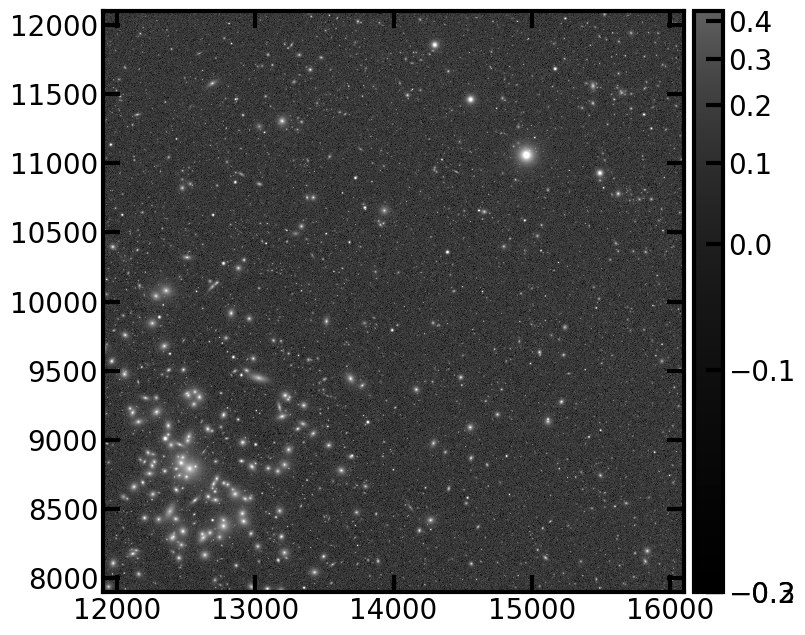

In [125]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()

#### 2.2.2. Retrieve catalog sources

This section demonstrates how to use TAP to retrieve the catalog data within a polygon defined by the corners of the coadd image.

The following cell extracts the XY values of the corners of the deepCoadd image and converts them to RA, Dec, which are then used as spatial constraints in the query below.

In [9]:
wcs = coadd.getWcs()

x0 = float(coadd.getX0())
y0 = float(coadd.getY0())
width = coadd.getWidth()
height = coadd.getHeight()

xcorners = [x0, x0+width, x0+width, x0]
ycorners = [y0, y0, y0+width, y0+width]

ra_corners = []
dec_corners = []

for i in range(len(xcorners)):
    radec = wcs.pixelToSky(xcorners[i], ycorners[i])
    ra_corners.append(radec.getRa().asDegrees())
    dec_corners.append(radec.getDec().asDegrees())


Create a query statement for objects within the bounding box corners and join them with the `TruthSummar` table to examine star-galaxy separation performance.

In [126]:
# build a comma-separated list of your corner coords
corner_str = ", ".join(
    f"{ra},{dec}"
    for ra, dec in zip(ra_corners, dec_corners)
)

query = f"""
SELECT
    mt.id_truth_type,
    mt.match_objectId,
    ts.truth_type,
    obj.objectId,
    obj.coord_ra,
    obj.coord_dec,
    scisql_nanojanskyToAbMag(obj.g_psfFlux) AS gmag, 
    scisql_nanojanskyToAbMag(obj.i_psfFlux) AS imag, 
    obj.refExtendedness
FROM dp02_dc2_catalogs.MatchesTruth AS mt
JOIN dp02_dc2_catalogs.TruthSummary AS ts
    ON mt.id_truth_type = ts.id_truth_type
JOIN dp02_dc2_catalogs.Object AS obj
    ON mt.match_objectId = obj.objectId
WHERE CONTAINS(
    POINT('ICRS', obj.coord_ra, obj.coord_dec),
    POLYGON('ICRS', {corner_str})) = 1
    AND obj.detect_isPrimary = 1
    AND obj.i_psfFluxErr > 0 
    AND obj.i_psfFlux/obj.i_psfFluxErr > 5
    AND obj.refExtendedness < 0.5
"""

Run the query as an asynchronous job.

In [93]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


Fetch the results and convert them to an Astropy table, then take a look at the table.

In [94]:
results = job.fetch_result().to_table()
results

id_truth_type,match_objectId,truth_type,objectId,coord_ra,coord_dec,gmag,imag,refExtendedness
,,,,deg,deg,,,
object,int64,int64,int64,float64,float64,float64,float64,float64
4939723723_1,1909948454470181615,1,1909948454470181615,55.7209631,-32.3143826,26.869482388214692,26.32180787941475,0.0
4938926768_1,1909886881819011524,1,1909886881819011524,55.7063139,-32.3179132,27.21150512192103,26.259385308411375,0.0
4938347532_1,1909948454470156574,1,1909948454470156574,55.7283283,-32.3161359,27.22060624962044,26.303274498769937,0.0
4938069271_1,1909886881819049732,1,1909886881819049732,55.7725256,-32.3216474,28.46965411133005,26.064814974130453,0.0
4937517775_1,1909948454470182614,1,1909948454470182614,55.7449069,-32.2986002,26.056898100881142,22.48351283149634,0.0
4943154303_1,1909948454470182637,1,1909948454470182637,55.7288023,-32.2953873,29.867832366956055,23.11632579735682,0.0
31102012186_2,1909948454470157221,2,1909948454470157221,55.7690507,-32.3003568,27.128436144259478,23.907989946557585,0.0
4940621672_1,1909948454470182621,1,1909948454470182621,55.7374204,-32.3001629,30.177956707881357,23.171757559041474,0.0


Display the image, and overplot the point-like objects on the image.

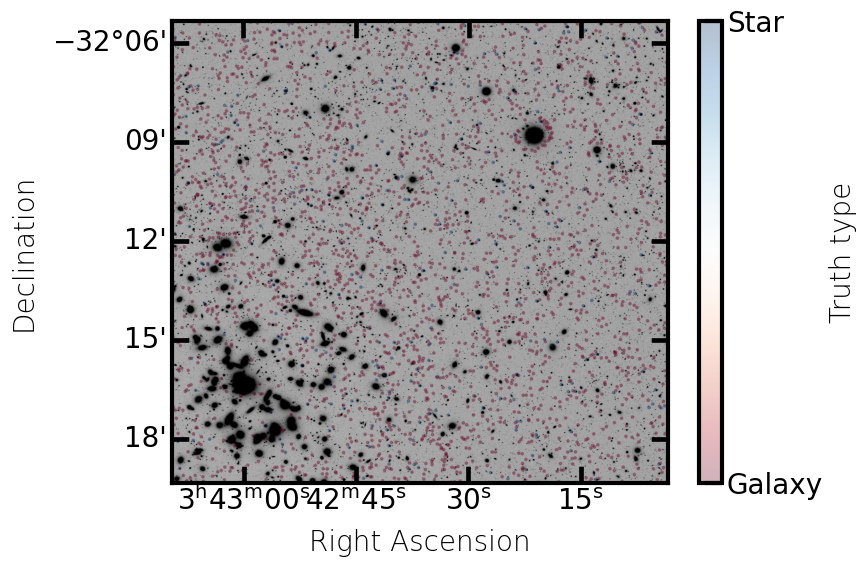

In [129]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection=WCS(wcs.getFitsMetadata()))
coadd_extent = (coadd.getBBox().beginX, coadd.getBBox().endX,
                coadd.getBBox().beginY, coadd.getBBox().endY)
ax.imshow(coadd.image.array, cmap='gray_r', vmin=-0.3, vmax=0.5,
          extent=coadd_extent, origin='lower', aspect='auto')
sc = ax.scatter(results['coord_ra'], results['coord_dec'], c=results['truth_type'], 
                transform=ax.get_transform('world'), cmap=plt.cm.RdBu, s=3)
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', label='Truth type')
cbar.set_ticks([1, 2])
cbar.set_ticklabels(['Galaxy', 'Star'])
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.show()

#### 2.2.3. Compare the truth object type and the `refExtendedness` value

Compare the `truth_type` from the `TruthSummary` table and the `refExtendedness` from the `Object` table using both a histrogram and on a color-magnitude diagram. 

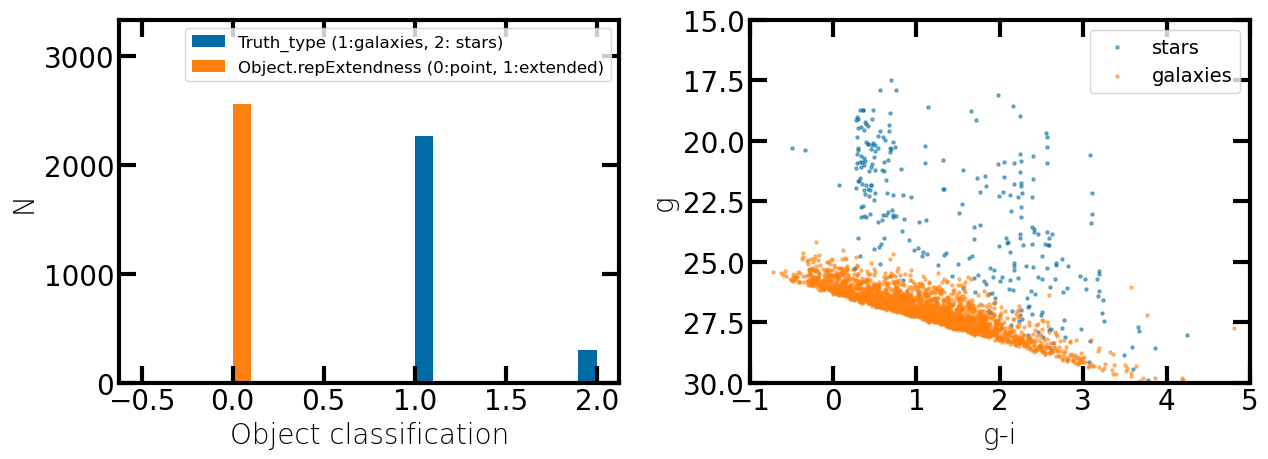

In [134]:
plt.figure(figsize=(13,5))

plt.subplot(121)
h = plt.hist(results['truth_type'], label='Truth_type (1:galaxies, 2: stars)')
h = plt.hist(results['refExtendedness'], label='Object.repExtendness (0:point, 1:extended)')
plt.legend(fontsize=12)
plt.ylim(0, 1.3*h[0].max())
plt.xlabel('Object classification')
plt.ylabel('N')

plt.subplot(122)
stars = results['truth_type'] == 2
galaxies = results['truth_type'] == 1
plt.scatter(results['gmag'][stars]-results['imag'][stars], 
            results['gmag'][stars], s=5, alpha=0.5, label='stars')
plt.scatter(results['gmag'][galaxies]-results['imag'][galaxies], 
            results['gmag'][galaxies], s=5, alpha=0.5, label='galaxies')
plt.legend()
plt.xlim(-1,5)
plt.ylim(30,15)
plt.xlabel('g-i')
plt.ylabel('g')

plt.tight_layout()

# 3. Milky Way Halo Density

In this section, we will derive distances to the BHB stars using a relationship from the literature. Then we will extract a radial density profile of BHB stars in the Milky Way.

The figure below highlights the final BHB stars selected using three different color–color spaces.

<img src="./images/bhb_selection.png" alt="BHB" width="400px" />

### 3.1. Measure the distance to individual BHB stars

In [109]:
# Read the FITS file:
bhb = Table.read('./bhb_dp02_final.fits')

From [Deason et al. 2011](https://ui.adsabs.harvard.edu/abs/2011MNRAS.416.2903D/abstract), the absolute magnitudes of BHB stars are related to their colors by:

$M_{g, BHB} = 0.434 − 0.169(g − r) + 2.319(g − r)^2 +20.449(g − r)^3 + 94.517(g − r)^4$

_Caveat: this relation is based on SDSS data. One should rederive the relation for DC2 to do this properly. Nonetheless, this likely only contributes a few percent error to the distances._

The following cell applies this relation to go from measured $g$ and $r$-band magnitudes to distances in kpc.

In [111]:
def bhbMagToDistKpc(gmag, rmag):
    gr = gmag-rmag
    M_g = 0.434 - (0.169*gr) + 2.319*(gr**2) + 20.449*(gr**3) + 94.517*(gr**4)
    distmod = gmag-M_g
    dist_pc = 10.0**((distmod + 5.0)/5.0)
    dist_kpc = dist_pc/1000.0
    return dist_kpc

In [112]:
# Get distances for our candidates:
bhb_dist_kpc = bhbMagToDistKpc(bhb['gmag0'], bhb['rmag0'])

In [114]:
sc_bhb = SkyCoord(ra=bhb['coord_ra']*u.deg,
                  dec=bhb['coord_dec']*u.deg,
                  distance=bhb_dist_kpc*u.kpc, frame='icrs')

The distances are as measured from the Sun ("heliocentric"). Since we're interested in the Milky Way's radial density profile, convert the distances to Galactocentric, then calculate the radial distance from the Galactic center. Thankfully, [Astropy](https://docs.astropy.org/en/stable/index.html)'s [SkyCoord](https://docs.astropy.org/en/stable/api/astropy.coordinates.SkyCoord.html) objects make this easy:

In [115]:
rad_bhb = np.sqrt(sc_bhb.galactocentric.x**2
                  + sc_bhb.galactocentric.y**2
                  + sc_bhb.galactocentric.z**2)

### 3.2. Compute the BHB density profile 

In [116]:
binwidth_kpc = 10.0
radbins = np.arange(0, 600, binwidth_kpc)
nbhb_bins, bhb_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bin_edges = bhb_bin_edges[:-1]
bin_centers = bin_edges+(binwidth_kpc/2)
volume_bins = np.array([(4.0/3.0)*np.pi*(((rad+binwidth_kpc)**3)-(rad**3)) for rad in bin_edges])
bhb_density_bins = nbhb_bins/volume_bins

nbhb_sel_bins, bhb_sel_bin_edges = np.histogram(rad_bhb.value, bins=radbins)
bhb_sel_density_bins = nbhb_sel_bins/volume_bins

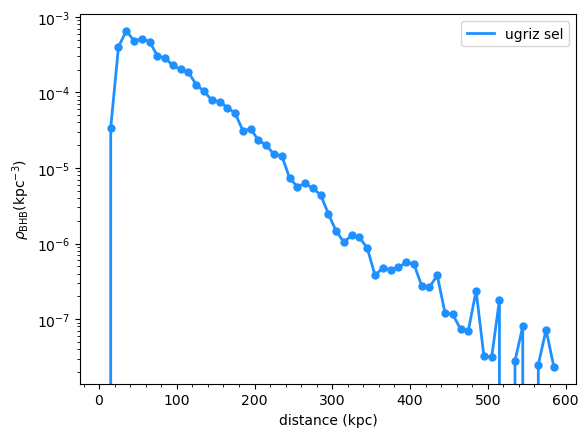

In [117]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='DodgerBlue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, '.', c='DodgerBlue', ms=10, label='__none__')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

### 3.3 Power-law fit

We fit a powerlaw to the density profile of the form $\rho \propto R^{-n}$, where $R$ is the Galactocentric radius, $\rho$ is the BHB density as a function of $R$, and $n$ is the powerlaw index.

Note that because BHB stars at distances $\lesssim 50$ kpc are bright and often saturated in the DC2 dataset, we limit the fit to $70 < R < 300$ kpc. We use the `numpy` function `polyfit`:

In [118]:
okfit_bins = (bin_centers > 70.0) & (bin_centers < 300.0)
bhb_sel_powerlaw_fit = np.polyfit(bin_centers[okfit_bins],
                                  np.log10(bhb_sel_density_bins[okfit_bins]),
                                  1)
print('Powerlaw fit: ', bhb_sel_powerlaw_fit)

bhb_sel_powerlaw = np.poly1d(bhb_sel_powerlaw_fit)

Powerlaw fit:  [-0.00946111 -2.70690827]


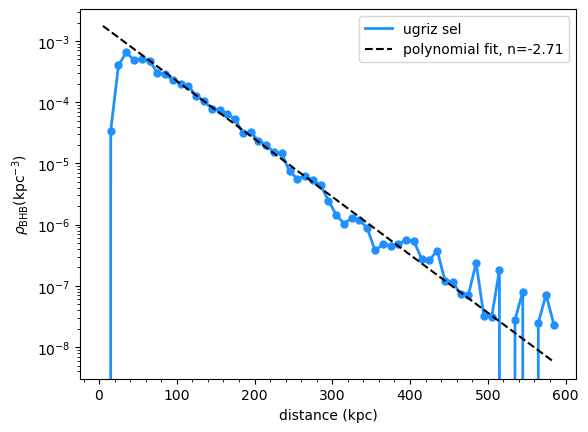

In [119]:
plt.plot(bin_centers, bhb_density_bins, linewidth=2, color='DodgerBlue', label='ugriz sel')
plt.plot(bin_centers, bhb_density_bins, '.', c='DodgerBlue', ms=10, label='__none__')
plt.plot(bin_centers, 10.0**bhb_sel_powerlaw(bin_centers), linestyle='--', color='black',
         label='polynomial fit, n='+f'{bhb_sel_powerlaw_fit[1]:.2f}')
plt.xlabel(r'distance (kpc)')
plt.ylabel(r'$\rho_{\rm BHB} ({\rm kpc}^{-3})$')
plt.legend()
plt.semilogy()
plt.minorticks_on()
plt.show()

From [Juric et al. 2008](https://ui.adsabs.harvard.edu/abs/2008ApJ...673..864J/abstract), Table 5, the best fit halo density profile from SDSS goes as $\sim R^{-2.8}$. The `galfast` model that went into DC2 used the Milky Way parameters from Juric+2008, so our "expected" result for the powerlaw should be $n_{expected} = 2.8$. We find $n = 2.7$, which is pretty excellent agreement given our rather simple methods!

#### Notes:
We don't necessarily expect that the Milky Way will have stars out to 600 kpc, given that its virial radius is thought to be ~300 kpc. However, the simulated dataset includes stars out to a cutoff radius of 1 Mpc (see these lines in the galfast code). Our density profile above suggests that we should be able to see a truncation in the Milky Way with BHB stars from LSST, if it exists.

In this exercise, we are not accounting for a possible non-spherical halo (e.g., Juric+2008 found oblate halo with q~0.6). However, with a dataset spanning only a small region of sky, that would be difficult to measure anyway.

Note also that we haven't include error bars on the density bins or profile fits. Those would make excellent "next steps."

Finally, a note that the narrow strip of BHB stars was relatively easy to pick out in this simulated DC2 data set. In real life, there are complications like blue straggler stars (not present in DC2, but with similar colors to BHBs), and substructure in the halo, that will make this much more difficult.